<a href="https://colab.research.google.com/github/cfreeman22/D213/blob/main/D213_task1_b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# D213 Advanced Data Analytics Task 1 Time Series Analysis

 

In [1]:
! pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from dateutil.parser import parse
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from scipy.signal import periodogram
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [3]:
#reading the data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Reading the data from my google drive.
data = pd.read_csv('/content/drive/My Drive/teleco_time_series .csv')

## __Data Preparation steps__

In [5]:
data.head()

,Day,Revenue
0,1,0.000000
1,2,0.000793
2,3,0.825542
3,4,0.320332
4,5,1.082554


In [6]:
# Setting the Day column as the index for easier processing
# Since there is no starting date mentioned, let us assume the first date of operation was Jan 1st, 2017
data.set_index('Day',inplace=True)
data.index=pd.to_datetime(data.index, unit = 'D', origin = '2017-01-01')

In [7]:
#checking for nulls
data.isnull().sum()

Revenue    0
dtype: int64

## __C1 Line graph visualization of the time series__

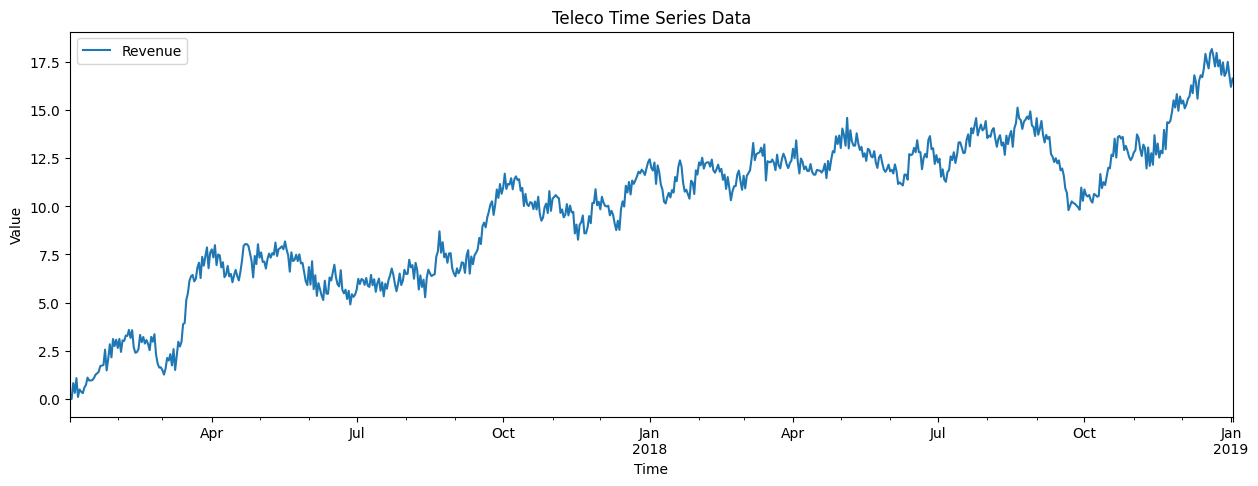

In [8]:
# Plotting the time series
data.plot(figsize=(15, 5))
plt.title("Teleco Time Series Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

The frequency is complete, which means there are no gaps in the data, and it is all equally spaced. The data presented no null values, and the length ranged from 0 to 730, with 731 rows and two columns. The first column, "Day," is set as the index to be more easily processed as a time series. The index is converted to a panda's datetime with a starting date of Jan 1st, 2017, assuming that this was the telecommunication company's first operation date.

## __C3 Evaluate the Stationarity of the Time Series__

To evaluate the stationarity of a time series, we can use various statistical tests such as the Augmented Dickey-Fuller (ADF) test or the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test. These tests check if the mean and variance of the time series are constant over time. The output below displays the ADF test statistic, p-value, and critical values at different confidence levels. If the p-value is less than a specified significance level (e.g., 0.05), we can reject the null hypothesis that the time series is non-stationary. Our crucial values for stationarity are -3.4, -2.8, and -2.5, respectively, and our test statistic is -1.9. We can see from this result that our data is not stationary because the test statistic is not below the crucial values.

In [9]:
# Define the ADF test function
def adf_test(timeseries):
    adf_result = adfuller(timeseries, autolag='AIC')
    adf_output = pd.Series(adf_result[0:4], index=['Test Statistic','p-value','# Lags Used','# Observations Used'])
    for key,value in adf_result[4].items():
        adf_output['Critical Value (%s)'%key] = value
    print(adf_output)

# Apply the ADF test to the data
adf_test(data['Revenue'])

Test Statistic           -1.924612
p-value                   0.320573
# Lags Used               1.000000
# Observations Used     729.000000
Critical Value (1%)      -3.439352
Critical Value (5%)      -2.865513
Critical Value (10%)     -2.568886
dtype: float64


## __C.4 Steps used to prepare the data for analysis__
- Adjusting the statonarity of the data
- Checking for nulls, duplicates
- Make a Clean copy
 

In [10]:
#Making time series stationary
data_diff = data.diff().dropna()
data_diff

,Revenue
Day,
2017-01-03,0.000793
2017-01-04,0.824749
2017-01-05,-0.505210
2017-01-06,0.762222
2017-01-07,-0.974900
...,...
2018-12-29,0.170280
2018-12-30,0.559108
2018-12-31,-0.687028


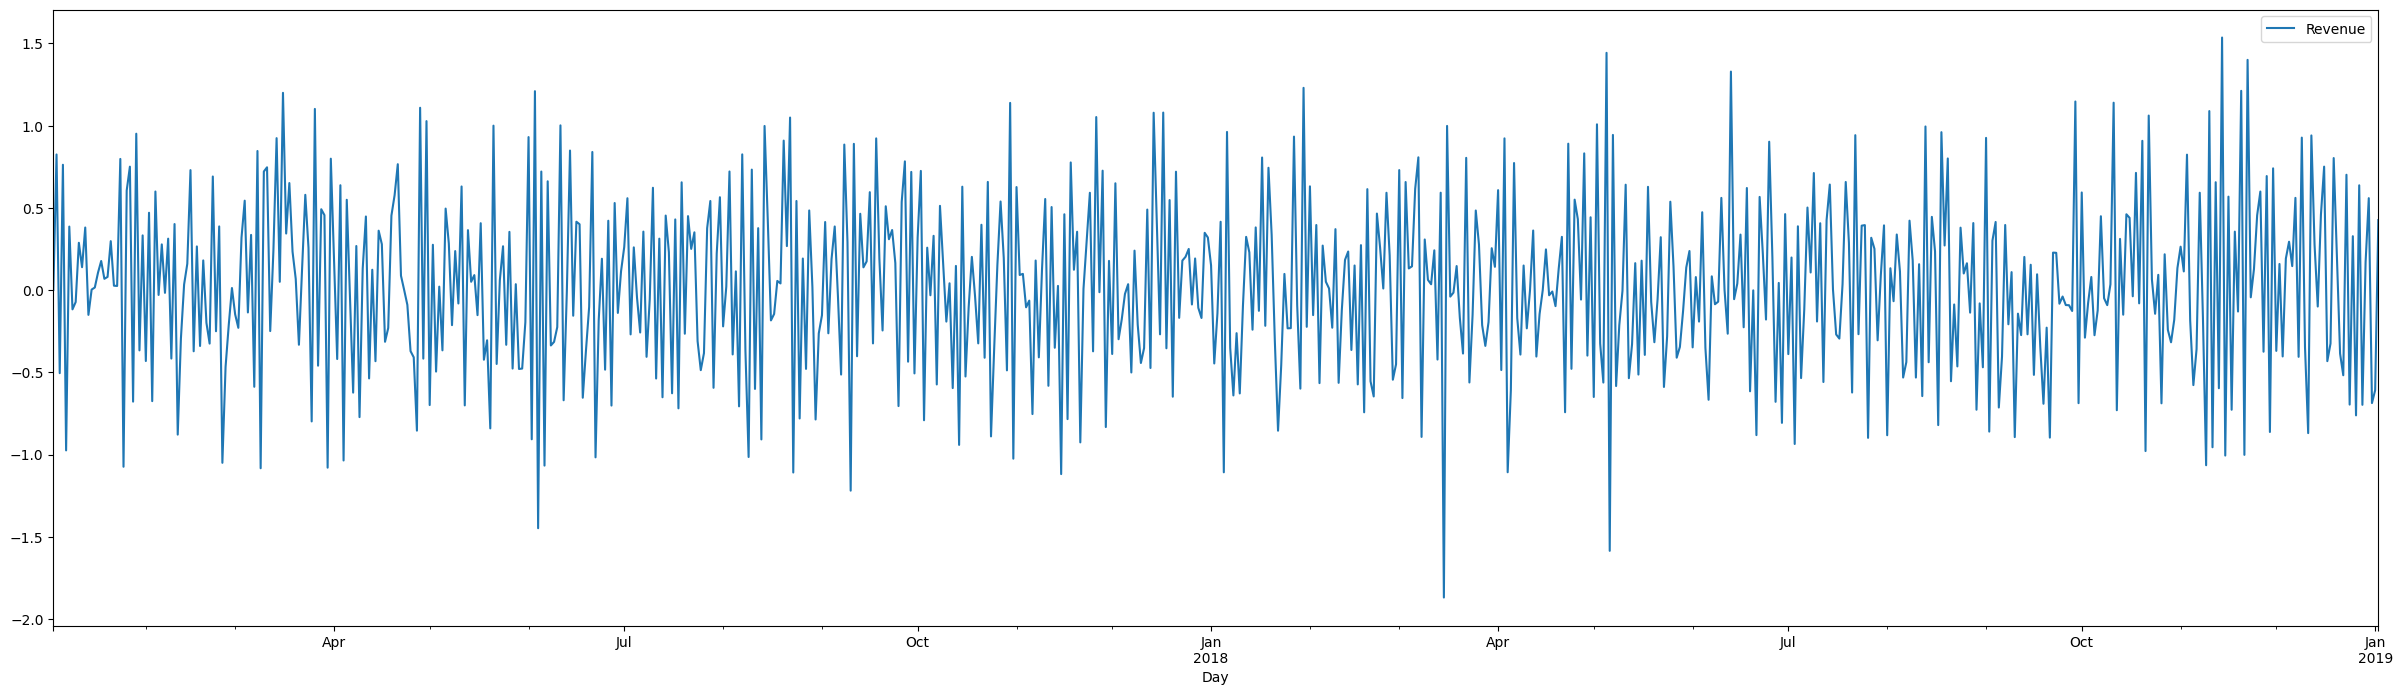

In [11]:
#Plotting the adjusted data
data_diff.plot(figsize=(30, 8))
plt.show()

In [12]:
#Testing Stationarity of the adjusted data
adf_test(data_diff['Revenue'])

Test Statistic          -44.874527
p-value                   0.000000
# Lags Used               0.000000
# Observations Used     729.000000
Critical Value (1%)      -3.439352
Critical Value (5%)      -2.865513
Critical Value (10%)     -2.568886
dtype: float64


In [13]:
#Checking for nulls
print(data_diff.isna().any())
print('****************')
#Checking for duplicates
print(data_diff.duplicated().any())

Revenue    False
dtype: bool
****************
False


In [14]:
# Saving a copy of cleaned data
#data_diff.to_csv('cleaned_time_series.csv', index = False)

We not notiocce above that the statistics have improved. -44 on this test is way lower than our crucial values for stationarity are -3.4, -2.8, and -2.5, respectively

## __D Model Identification and Analysis__

In [15]:
#splitting the data
train = data_diff.iloc[:365]
test = data_diff.iloc[365:]



In [16]:
# Use auto_arima with trace on to fit the ARIMA model
arima_model = auto_arima(train, trace=1)

# Print the optimal p, d, and q values
print('Optimal p: {}'.format(arima_model.order[0]))
print('Optimal d: {}'.format(arima_model.order[1]))
print('Optimal q: {}'.format(arima_model.order[2]))

# Fit the ARIMA model to the training data
arima_model.fit(train)

# Make predictions on the test data
predictions = arima_model.predict(n_periods=365)

# Print the predictions
print(predictions)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=489.115, Time=1.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=577.845, Time=0.36 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=484.771, Time=0.28 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=507.989, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=577.239, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=485.957, Time=0.31 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=486.101, Time=0.42 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=487.257, Time=1.48 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=486.801, Time=0.10 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 4.616 seconds
Optimal p: 1
Optimal d: 0
Optimal q: 0
2018-01-03    0.262849
2018-01-04   -0.076569
2018-01-05    0.085898
2018-01-06    0.008131
2018-01-07    0.045355
                ...   
2018-12-29    0.033305
2018-12-30    0.033305
2018-12-31    0.033305
2019-01-01    0.033305
2019-01-02    0.033305
Fre

In [17]:
from statsmodels.tsa.arima.model import ARIMA

# 1,0,0 ARIMA Model
model = ARIMA(train, order=(1,0,0), freq = "D")
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  365
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -239.386
Date:                Thu, 20 Apr 2023   AIC                            484.771
Time:                        01:37:34   BIC                            496.471
Sample:                    01-03-2017   HQIC                           489.421
                         - 01-02-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0333      0.017      2.002      0.045       0.001       0.066
ar.L1         -0.4787      0.047    -10.186      0.000      -0.571      -0.387
sigma2         0.2172      0.018     12.108      0.0

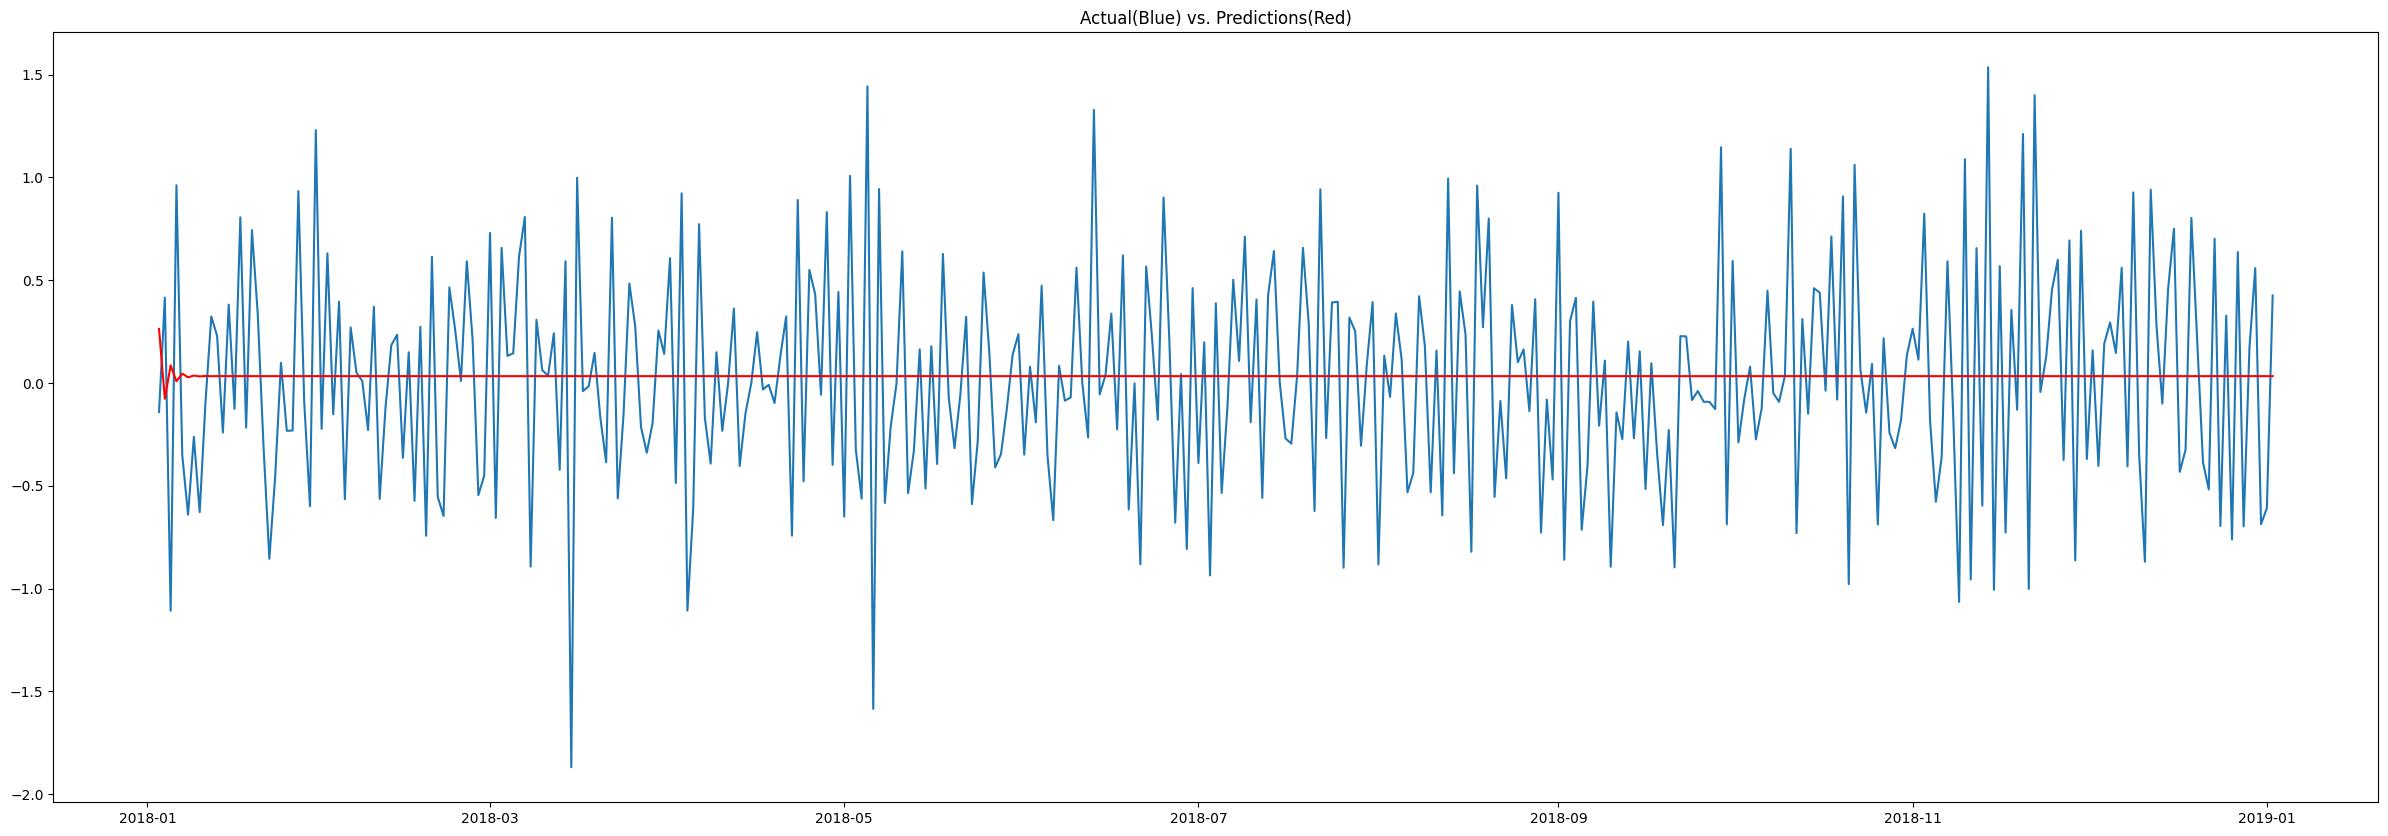

In [18]:
# plot forecasts vs actual outcomes
plt.figure(figsize=(30,10))
plt.title('Actual(Blue) vs. Predictions(Red)')
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

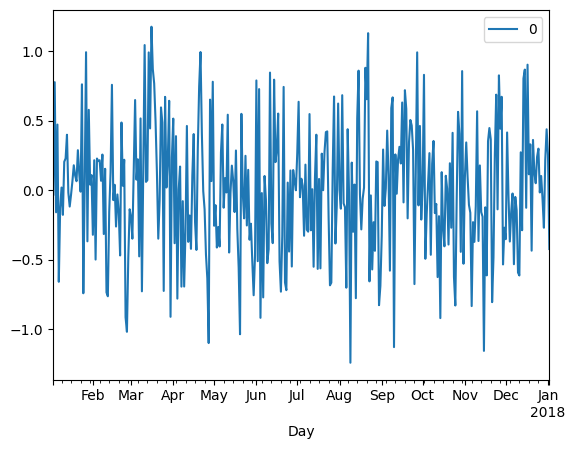

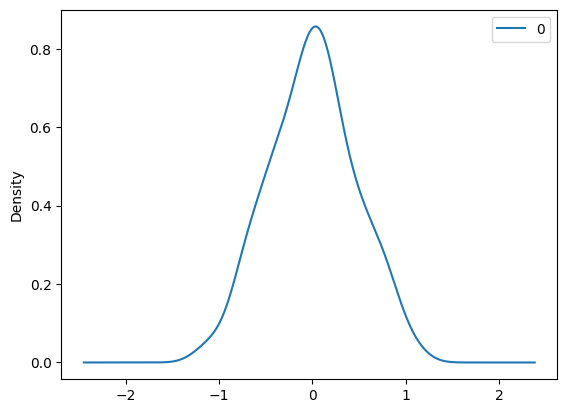

                0
count  365.000000
mean    -0.000035
std      0.466699
min     -1.241190
25%     -0.327385
50%      0.003975
75%      0.290219
max      1.174592


In [19]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [20]:
result = seasonal_decompose(data_diff['Revenue'], model='additive', period=1)

<Axes: xlabel='Day'>

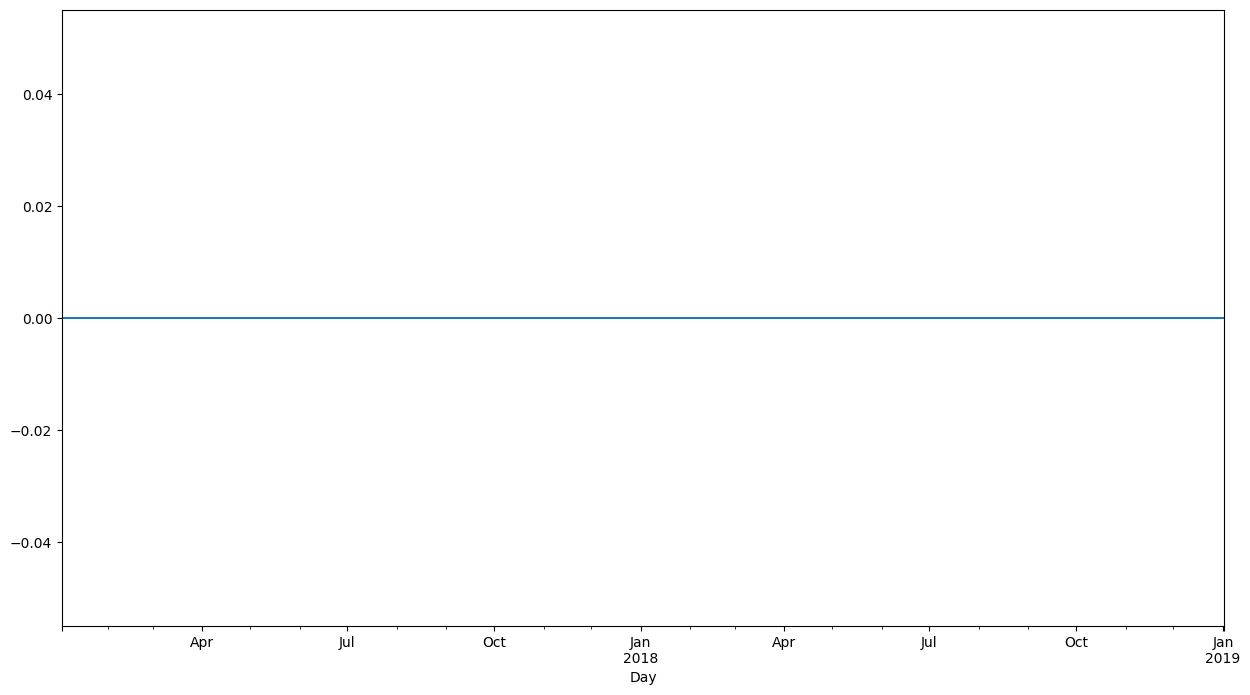

In [21]:
#Seasonal Plot
result.seasonal.plot(figsize=(15, 8))
#result.plot();

<Axes: xlabel='Day'>

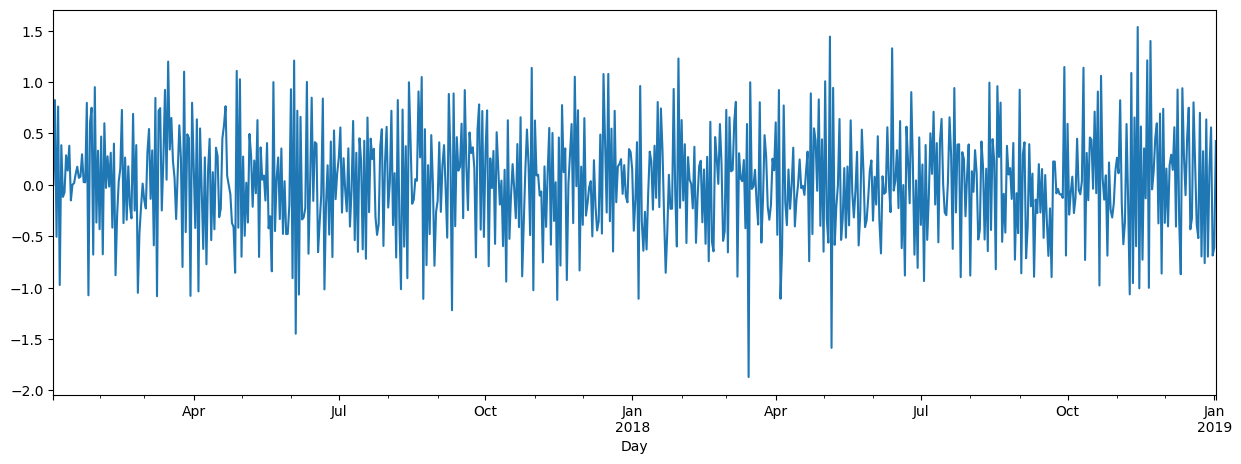

In [22]:
#Trend Plot
result.trend.plot(figsize=(15, 5))

In [23]:
#Autocorrelation Plot
fig = plot_acf(telco_stat)
fig.set_size_inches(20, 15)
plt.show(fig)

NameError: ignored

In [ ]:
# Compute the ACF for the time series data
 

# Create a line plot of the ACF values
#plt.plot(acf_values)
acf_values = plot_acf(data_diff)
acf_values.set_size_inches(20, 5)
# Set the plot title and axis labels
plt.title('Autocorrelation Function Plot')

plt.ylabel('Autocorrelation')

# Show the plot
plt.show()

In [ ]:
# Compute the spectral density for the time series data
freq, power = periodogram(data_diff['Revenue']) 
 # Create a line plot of the spectral density 
plt.plot(freq, power) 
 # Set the plot title and axis labels 
plt.title('Spectral Density Plot') 
plt.xlabel('Frequency') 
plt.ylabel('Power') 

 # Show the plot 
plt.show()